In [1]:
import glob
import pathlib
import pickle
import numpy as np
import sys
import os
from music21 import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

sys.path.append("..")
from musiclearn import config
from musiclearn.sequential_models import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Processing and Exploration

In [2]:
# path to Schubert collection
schubert_dir = pathlib.Path(config.MUSICNET_MIDI_DIR) / "Schubert"
#schubert_dir = pathlib.Path(config.MUSICNET_MIDI_DIR) / "schubert"

# path to final fantasy collection
ff_dir = pathlib.Path(config.FF_MIDI_DIR)

# path to location of tensorboard logs
logs_dir = pathlib.Path(config.LOGS_DIR)

In [3]:
# length of an input sequence
SEQUENCE_LENGTH = 100

In [4]:
def get_notes(midi_dir):
    """ Get all the notes and chords from the midi files in a collection """
    notes = []
    
    noteFile_dir = str(midi_dir) + "/notes"
    
    if not os.path.exists(noteFile_dir):
        files_dir = str(midi_dir) + "/*.mid"
        for file in glob.glob(files_dir):
            midi = converter.parse(file)

            print("Parsing %s" % file)

            notes_to_parse = None

            try: # file has instrument parts
                s2 = instrument.partitionByInstrument(midi)
                notes_to_parse = s2.parts[0].recurse()
            except: # file has notes in a flat structure
                notes_to_parse = midi.flat.notes

            for element in notes_to_parse:
                if isinstance(element, note.Note):
                     notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

        # save the features
        with open(noteFile_dir, 'wb') as fp:
            pickle.dump(notes, fp)
    else:
        with open(noteFile_dir, 'rb') as fp:
            notes = pickle.load(fp)
    
    return notes

In [5]:
def read_midi(midi_dir):
    """ Read all midi file in the collection and return the notes """
    notes = []
    
    noteFile_dir = str(midi_dir) + "/notes"
    
    if not os.path.exists(noteFile_dir):
        files_dir = str(midi_dir) + "/*.mid"
        for file in glob.glob(files_dir):
            midi = converter.parse(file)

            print("Parsing %s" % file)

            notes_to_parse = None

            try: # file has instrument parts
                s2 = instrument.partitionByInstrument(midi)
                
                # looping over all the instrument parts
                for part in s2.parts:
                    #select elements of piano
                    if "Piano" in str(part):
                        notes_to_parse = part.recurse()
            except: # file has notes in a flat structure
                notes_to_parse = midi.flat.notes

            # if there are notes to parse
            if notes_to_parse is not None:
                for element in notes_to_parse:
                    if isinstance(element, note.Note):
                         notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))

        # save the features
        with open(noteFile_dir, 'wb') as fp:
            pickle.dump(notes, fp)
    else:
        with open(noteFile_dir, 'rb') as fp:
            notes = pickle.load(fp)
    
    return notes

In [6]:
# extract the notes
#notes = get_notes(schubert_dir)
notes = read_midi(schubert_dir)

In [7]:
# get the number of unique notes
pitchNames = sorted(set(item for item in notes))
n_vocab = len(pitchNames)
print("No. unique notes =", n_vocab)

No. unique notes = 312


In [8]:
pitchNames

['0',
 '0.1',
 '0.1.6',
 '0.2',
 '0.2.5',
 '0.2.5.8',
 '0.2.6',
 '0.2.6.8',
 '0.2.7',
 '0.3',
 '0.3.4',
 '0.3.5',
 '0.3.6',
 '0.3.6.8',
 '0.3.6.9',
 '0.3.7',
 '0.4',
 '0.4.5',
 '0.4.6',
 '0.4.7',
 '0.4.8',
 '0.5',
 '0.6',
 '1',
 '1.2',
 '1.2.6',
 '1.3',
 '1.3.6',
 '1.3.6.9',
 '1.3.7',
 '1.3.8',
 '1.4',
 '1.4.6',
 '1.4.7',
 '1.4.7.10',
 '1.4.7.9',
 '1.4.7.9.10',
 '1.4.8',
 '1.5',
 '1.5.7',
 '1.5.8',
 '1.5.9',
 '1.6',
 '1.7',
 '10',
 '10.0',
 '10.0.2',
 '10.0.3',
 '10.0.4',
 '10.0.5',
 '10.1',
 '10.1.3',
 '10.1.4',
 '10.1.4.5',
 '10.1.4.6',
 '10.1.5',
 '10.2',
 '10.2.3',
 '10.2.4',
 '10.2.5',
 '10.3',
 '11',
 '11.0',
 '11.0.4',
 '11.1',
 '11.1.4',
 '11.1.4.6',
 '11.1.4.7',
 '11.1.5',
 '11.1.6',
 '11.2',
 '11.2.4',
 '11.2.4.7',
 '11.2.5',
 '11.2.5.7',
 '11.2.6',
 '11.3',
 '11.3.5',
 '11.3.6',
 '11.4',
 '2',
 '2.3',
 '2.3.7',
 '2.4',
 '2.4.6',
 '2.4.7',
 '2.4.8',
 '2.4.8.9',
 '2.4.9',
 '2.5',
 '2.5.7',
 '2.5.8',
 '2.5.8.10',
 '2.5.8.11',
 '2.5.8.9',
 '2.5.9',
 '2.6',
 '2.6.10',
 '2.6.8',
 

In [9]:
# create a dictionary to map notes to unique integers
note_to_int = dict((note, number) for number, note in enumerate(pitchNames))

# create a dictionary to map unique integers to notes
int_to_note = dict((number, note) for number, note in enumerate(pitchNames))

In [10]:
def prepare_sequences(sequence_length, notes, n_vocab, note_to_int):
    """ Prepare the sequences used by the neural network """   
    network_input = []
    network_output = []
    
    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i : i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
        
    n_samples = len(network_input)
    
    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_samples, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)
    
    network_output = np.array(network_output)
    
    return (network_input, network_output)

In [11]:
# test prepare_sequences()
network_input, network_output = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
print(network_input.shape)
print(network_output.shape)

(78937, 100, 1)
(78937,)


In [12]:
def create_midi(notes_list, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in notes_list:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

In [13]:
def train_model(model, sequence_length, notes, n_vocab, note_to_int, model_name, epochs=20, batch_size=128):
    """ Train a neural network to generate music """
    # get amount of pitch names
    n_vocab = len(set(notes))
    
    network_input, network_output = prepare_sequences(sequence_length, notes, n_vocab, note_to_int)

    #model = lstm_model(network_input.shape, n_vocab)
    
    # train the network
    filepath = model_name + "_saved_weights.hdf5"
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        node='min'
    )
    
    log_dir = str(logs_dir / "logs" / model_name)
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                     write_graph=True,
                                     write_images=True,
                                     update_freq='epoch'
                                )
    
    callback_list = [checkpoint_cb, tensorboard_cb]
    
    model.fit(network_input, 
              network_output, 
              epochs=epochs, 
              batch_size=batch_size, 
              callbacks=callback_list,
              validation_split=0.2
             )

In [14]:
def generate_notes(model, network_input, int_to_note, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    pattern = network_input[start]
    prediction_output = []

    # generate 100 notes
    for note_index in range(100):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        #pattern.append(index)
        pattern = np.append(pattern, [index])
        pattern = pattern[1:]

    return prediction_output

## LSTM Model

In [34]:
def lstm_model(input_shape, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(input_shape[1], input_shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.3))
    model.add((LSTM(512, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(512))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))
    
    # optimizer
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    
    return model

In [35]:
K.clear_session()

In [36]:
# test code to output model architecture
network_input, network_output = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
lstm_model = lstm_model(network_input.shape, n_vocab)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1052672   
_________________________________________________________________
dropout (Dropout)            (None, 100, 512)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

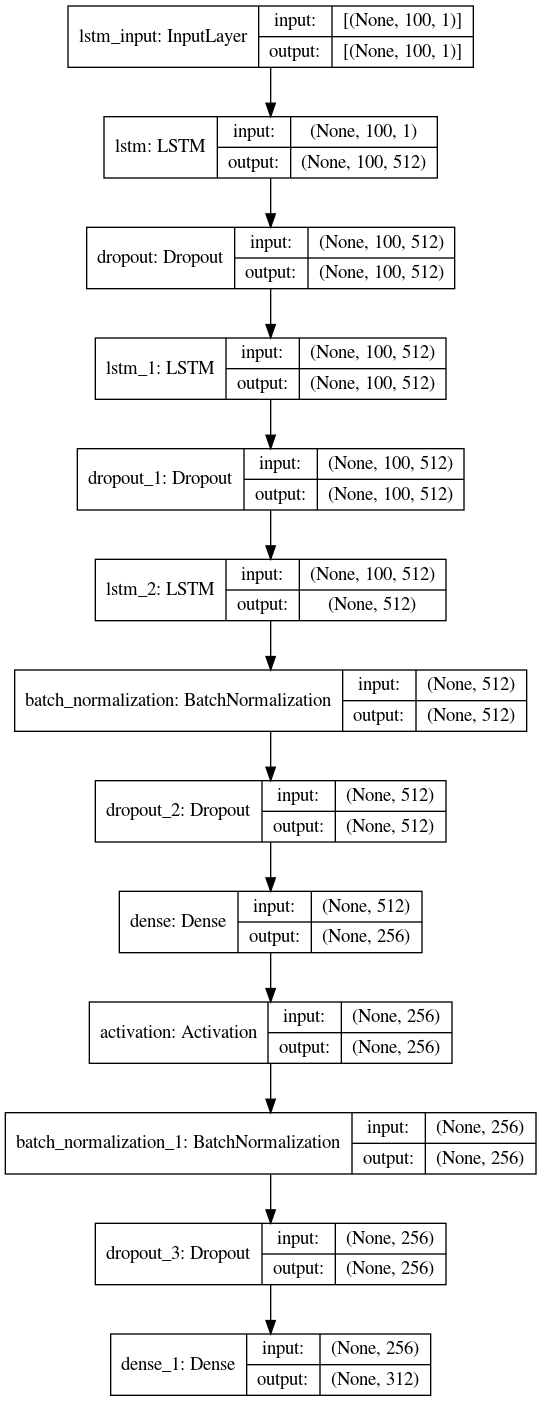

In [37]:
plot_model(lstm_model, show_shapes=True)

In [ ]:
# train the model
train_model(lstm_model, SEQUENCE_LENGTH, notes, n_vocab, note_to_int, "lstm", 100, 64)

In [ ]:
def load_lstm_model():
    """ Load the saved LSTM model """
    
    model = tf.keras.models.load_model('lstm_saved_weights.hdf5')
    
    return model

In [ ]:
# generate a new midi file from the train model
noteFile_dir = str(schubert_dir / "notes")
    
# load the notes used to train the model
with open(noteFile_dir, 'rb') as fp:
    notes = pickle.load(fp)

network_input, _ = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
print(network_input[0].shape)
    
# load saved weights
model = load_lstm_model()

for i in range(10):
    # generate a new sequence
    prediction_output = generate_notes(model, network_input, int_to_note, n_vocab)
    
    fn = "lstm_output_sample_{n}.mid".format(n=i)

     # make midi file
    create_midi(prediction_output, fn)

## Bidirectional LSTM

In [38]:
def bidirectional_lstm_model(input_shape, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=(input_shape[1], input_shape[2])))
    
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(512)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    
    return model

In [39]:
K.clear_session()

In [40]:
# test code to output model architecture
network_input, network_output = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
bidirectional_lstm_model = bidirectional_lstm_model(network_input.shape, n_vocab)
bidirectional_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 1024)         2105344   
_________________________________________________________________
dropout (Dropout)            (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

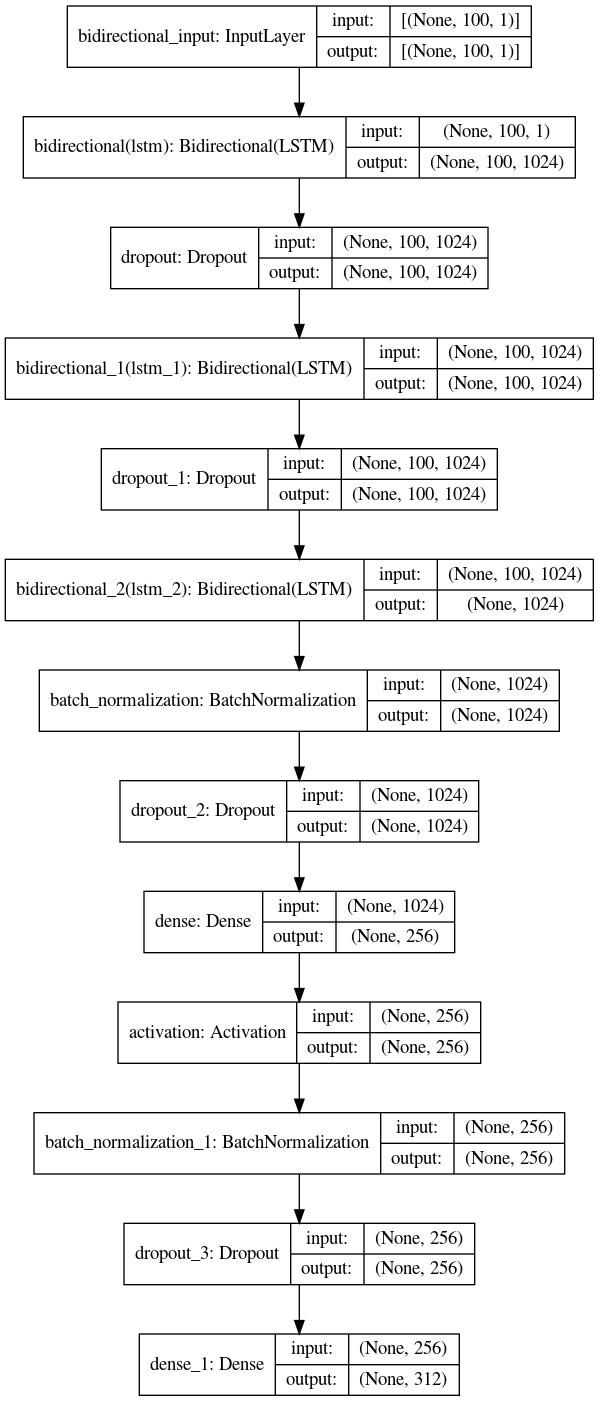

In [41]:
plot_model(bidirectional_lstm_model, show_shapes=True)

In [ ]:
# train the model
train_model(bidirectional_lstm_model, SEQUENCE_LENGTH, notes, n_vocab, note_to_int, "bidirect_lstm", 100, 64)

In [ ]:
def load_bidirectional_lstm_model():
    """ Load the saved LSTM model """
    
    model = tf.keras.models.load_model('bidirect_lstm_saved_weights.hdf5')
    
    return model

In [ ]:
# generate a new midi file from the train model
noteFile_dir = str(schubert_dir / "notes")
    
# load the notes used to train the model
with open(noteFile_dir, 'rb') as fp:
    notes = pickle.load(fp)

network_input, _ = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
print(network_input[0].shape)
    
# load saved weights
model = load_bidirectional_lstm_model()

for i in range(10):
    # generate a new sequence
    prediction_output = generate_notes(model, network_input, int_to_note, n_vocab)
    
    fn = "bidirect_lstm_output_sample_{n}.mid".format(n=i)

     # make midi file
    create_midi(prediction_output, fn)

## LSTM with Attention

In [23]:
class Customized_Attention(Layer):
    """ Attention block """
    def __init__(self, return_sequences=True):
        self.return_sequences=return_sequences
        super().__init__()
        
        
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        super().build(input_shape)
        
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)
    
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({'return_sequences': self.return_sequences})
        return config
    

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [24]:
def attention_lstm_model(input_shape, n_vocab):
    """ Construct a model based on LSTM and attention """
    model = Sequential()
    
    # Bidirectional LSTM layer with attention
    model.add(Bidirectional(LSTM(512, return_sequences=True), 
                            input_shape=(input_shape[1], input_shape[2])
                           )
             )
    model.add(Customized_Attention(return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Second bidirectional LSTM layer with attention
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Customized_Attention(return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))
    
    # compile
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    
    return model

In [25]:
K.clear_session()

In [26]:
# test the architecture
network_input, network_output = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
attention_lstm_model = attention_lstm_model(network_input.shape, n_vocab)
attention_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 1024)         2105344   
_________________________________________________________________
customized__attention (Custo (None, 100, 1024)         1124      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 1024)         4096      
_________________________________________________________________
dropout (Dropout)            (None, 100, 1024)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 1024)         6295552   
_________________________________________________________________
customized__attention_1 (Cus (None, 100, 1024)         1124      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 1024)         4

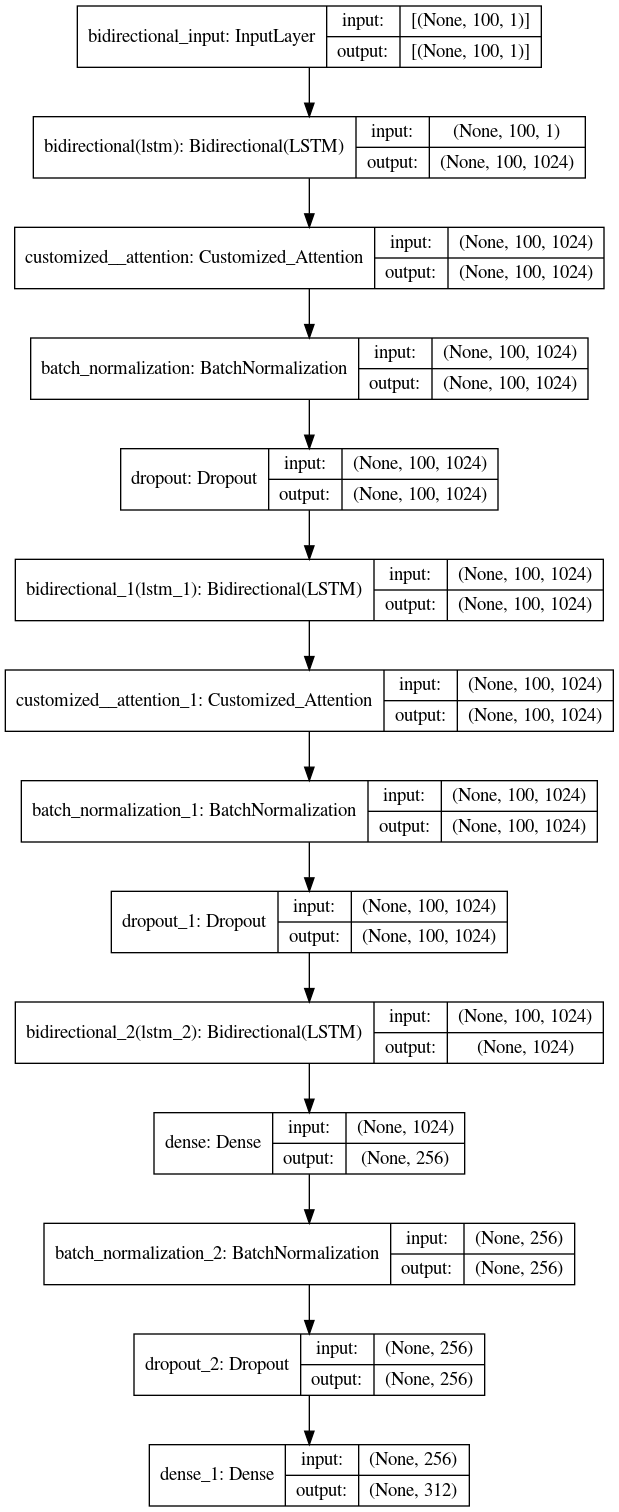

In [33]:
plot_model(attention_lstm_model, show_shapes=True)

In [27]:
# train the model
train_model(attention_lstm_model, SEQUENCE_LENGTH, notes, n_vocab, note_to_int, "attention_lstm", 100, 64)

Epoch 1/100
987/987 [==============================] - 108s 105ms/step - loss: 4.8596 - val_loss: 267.1143
Epoch 2/100
987/987 [==============================] - 103s 105ms/step - loss: 4.6555 - val_loss: 77.8544
Epoch 3/100
987/987 [==============================] - 104s 105ms/step - loss: 4.6439 - val_loss: 530.1245
Epoch 4/100
987/987 [==============================] - 103s 105ms/step - loss: 4.6212 - val_loss: 110.3202
Epoch 5/100
987/987 [==============================] - 103s 104ms/step - loss: 4.6184 - val_loss: 514.2358
Epoch 6/100
987/987 [==============================] - 103s 105ms/step - loss: 4.5910 - val_loss: 143.2824
Epoch 7/100
987/987 [==============================] - 104s 105ms/step - loss: 4.5762 - val_loss: 68.3789
Epoch 8/100
987/987 [==============================] - 103s 105ms/step - loss: 4.5569 - val_loss: 137.3294
Epoch 9/100
987/987 [==============================] - 103s 104ms/step - loss: 4.5437 - val_loss: 58.4021
Epoch 10/100
987/987 [==================

987/987 [==============================] - 103s 104ms/step - loss: 0.4408 - val_loss: 8.1853
Epoch 79/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4332 - val_loss: 8.6166
Epoch 80/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4293 - val_loss: 8.3875
Epoch 81/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4213 - val_loss: 8.5454
Epoch 82/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4252 - val_loss: 8.4109
Epoch 83/100
987/987 [==============================] - 104s 105ms/step - loss: 0.4252 - val_loss: 8.5498
Epoch 84/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4186 - val_loss: 8.5804
Epoch 85/100
987/987 [==============================] - 103s 104ms/step - loss: 0.4205 - val_loss: 8.5299
Epoch 86/100
987/987 [==============================] - 103s 105ms/step - loss: 0.4211 - val_loss: 8.4180
Epoch 87/100
987/987 [==============================] - 103

In [30]:
def load_attention_lstm_model(input_shape, n_vocab):
    """ Load the saved weights """
    #model = tf.keras.models.load_model("attention_lstm_saved_weight.hdf5")
    
    model = Sequential()
    
    # Bidirectional LSTM layer with attention
    model.add(Bidirectional(LSTM(512, return_sequences=True), 
                            input_shape=(input_shape[1], input_shape[2])
                           )
             )
    model.add(Customized_Attention(return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    # Second bidirectional LSTM layer with attention
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Customized_Attention(return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))
    
    # compile
    model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
    
    model.load_weights("attention_lstm_saved_weights.hdf5")
    
    return model

In [31]:
# generate a new midi file from the train model
noteFile_dir = str(schubert_dir / "notes")
    
# load the notes used to train the model
with open(noteFile_dir, 'rb') as fp:
    notes = pickle.load(fp)

network_input, _ = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
print(network_input[0].shape)
    
# load saved weights
model = load_attention_lstm_model(network_input.shape, n_vocab)

for i in range(10):
    # generate a new sequence
    prediction_output = generate_notes(model, network_input, int_to_note, n_vocab)
    
    fn = "attention_lstm_output_sample_{n}.mid".format(n=i)

     # make midi file
    create_midi(prediction_output, fn)

(100, 1)


## WaveNet model

In [ ]:
K.clear_session()

In [42]:
def simplified_wavenet(n_vocab, sequence_length, input_shape):
    """ A simplified version of WaveNet without residual and skip connection """
    model = Sequential()
    
    # causal convolution
    model.add(Conv1D(64, 3, padding='causal', activation='relu', 
                     input_shape=(input_shape[1], input_shape[2])
                    )
             )
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))
    
    # dialated causal convolution
    model.add(Conv1D(128, 3,activation='relu',dilation_rate=2,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))

    model.add(Conv1D(256, 3,activation='relu',dilation_rate=4,padding='causal'))
    model.add(Dropout(0.2))
    model.add(MaxPool1D(2))
    
    model.add(Conv1D(256,5,activation='relu'))    
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_vocab, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    
    return model

In [43]:
# prepare the input to the model
X, Y = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)

In [44]:
# build the model
wavenet_model = simplified_wavenet(n_vocab, SEQUENCE_LENGTH, X.shape)
wavenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 64)           256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 128)           24704     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 256)          

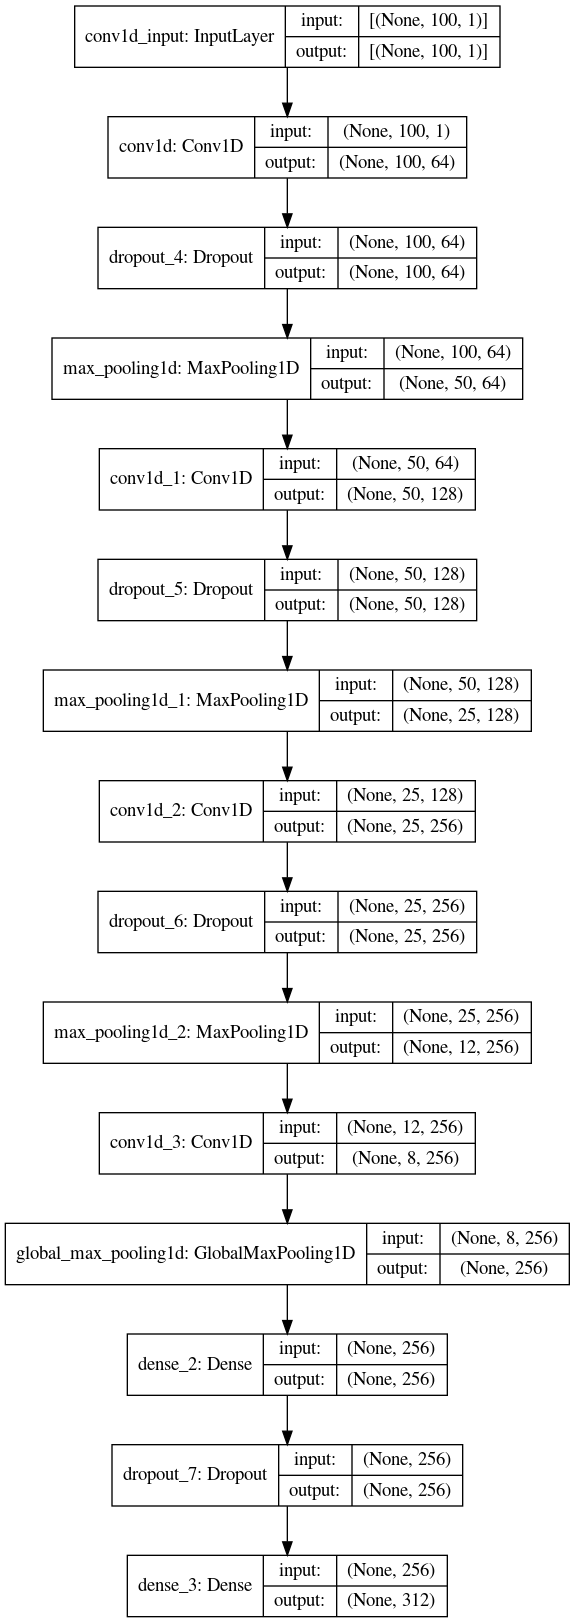

In [45]:
plot_model(wavenet_model, show_shapes=True)

In [ ]:
# train the model
train_model(wavenet_model, SEQUENCE_LENGTH, notes, n_vocab, note_to_int, "wavenet", 100, 64)

In [ ]:
def load_wavenet_model():
    """ Load the saved weights of the WaveNet model """
    model = tf.keras.models.load_model('wavenet_saved_weights.hdf5')
    
    return model

In [ ]:
# generate a new midi file from the train model
noteFile_dir = str(schubert_dir / "notes")
    
# load the notes used to train the model
with open(noteFile_dir, 'rb') as fp:
    notes = pickle.load(fp)

network_input, _ = prepare_sequences(SEQUENCE_LENGTH, notes, n_vocab, note_to_int)
print(network_input[0].shape)
    
# load saved weights
model = load_wavenet_model()

for i in range(10):
    # generate a new sequence
    prediction_output = generate_notes(model, network_input, int_to_note, n_vocab)
    
    fn = "wavenet_output_sample_{n}.mid".format(n=i)

     # make midi file
    create_midi(prediction_output, fn)